In [40]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [41]:
SOS_token = 0
EOS_token = 1
MAX_LENGTH = 10

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1


class PrepareData:
    def __init__(self, lang1, lang2, reverse=False):
    
        self.eng_prefixes = (
            "i am ", "i m ",
            "he is", "he s ",
            "she is", "she s ",
            "you are", "you re ",
            "we are", "we re ",
            "they are", "they re "
        )

        self.lang1 = lang1
        self.lang2 = lang2
        self.reverse = reverse
    # Turn a Unicode string to plain ASCII
    def unicodeToAscii(self, s):
        return ''.join(
            c for c in unicodedata.normalize('NFD', s)
            if unicodedata.category(c) != 'Mn'
        )

    # Lowercase, trim, and remove non-letter characters
    def normalizeString(self, s):
        s = self.unicodeToAscii(s.lower().strip())
        s = re.sub(r"([.!?])", r" \1", s)
        s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
        return s

    def normalizeString_korean(self, s):
        # s = self.unicodeToAscii(s.lower().strip())
        s = re.sub(r"([.!?])", r" \1", s)
        # s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
        return s

    def readLangs(self):
        print("Reading lines...")

        # Read the file and split into lines
        lines = open('data/%s-%s.txt' % (self.lang1, self.lang2), encoding='utf-8').read().strip().split('\n')

        # Split every line into pairs and normalize
        pairs = [[s for s in l.split('\t')[0:2]] for l in lines]
        pairs = [[self.normalizeString(pair[0]), self.normalizeString_korean(pair[1])] for pair in pairs]
        print("Read %s sentence pairs" % len(pairs))

        # Reverse pairs, make Lang instances
        if self.reverse:
            pairs = [list(reversed(p)) for p in pairs]
            input_lang = Lang(self.lang2)
            output_lang = Lang(self.lang1)
        else:
            input_lang = Lang(self.lang1)
            output_lang = Lang(self.lang2)
        
        pairs = self.filterPairs(pairs)
        print("Trimmed to %s sentence pairs" % len(pairs))
        print("Counting words...")
        for pair in pairs:
            input_lang.addSentence(pair[0])
            output_lang.addSentence(pair[1])
        print("Counted words:")
        print(input_lang.name, input_lang.n_words)
        print(output_lang.name, output_lang.n_words)
        
        return input_lang, output_lang, pairs

    def filterPair(self, p):
        return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH
            # and p[1].startswith(self.eng_prefixes)

    def filterPairs(self, pairs):
        return [pair for pair in pairs if self.filterPair(pair)]



In [42]:
data_process = PrepareData('eng', 'kor', True)
input_lang, output_lang, pairs = data_process.readLangs()
print(random.choice(pairs))

Reading lines...
Read 3640 sentence pairs
Trimmed to 3164 sentence pairs
Counting words...
Counted words:
kor 4558
eng 2201
['그사람이 말하려고 했어 .', 'he was about to speak .']


In [43]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


In [44]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [45]:
teacher_forcing_ratio = 0.5

import time
import math
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
from tqdm import tqdm_notebook as tqdm
import matplotlib.font_manager as fm

font = fm.FontProperties(fname='/home/dspserver/.local/lib/python3.5/site-packages/matplotlib/mpl-data/fonts/ttf/NanumGothic-Regular.ttf')

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()


def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90, fontproperties=font)
    ax.set_yticklabels([''] + output_words, fontproperties=font)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


class Machine_Translation:

    def __init__(self, hidden_size=256):

        self.hidden_size = hidden_size
        self.encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
        self.decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

        self.criterion = nn.NLLLoss()
        self.max_length = MAX_LENGTH
    

    def process_batch(self, input_tensor, target_tensor):

        encoder_hidden = self.encoder.initHidden()

        input_length = input_tensor.size(0)
        target_length = target_tensor.size(0)

        encoder_outputs = torch.zeros(self.max_length, self.hidden_size, device=device)

        loss = 0

        for ei in range(input_length):
            encoder_output, encoder_hidden = self.encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] = encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoder_hidden = encoder_hidden

        use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

        if use_teacher_forcing:
            # Teacher forcing: Feed the target as the next input
            for di in range(target_length):
                decoder_output, decoder_hidden, decoder_attention = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
                loss += self.criterion(decoder_output, target_tensor[di])
                decoder_input = target_tensor[di]  # Teacher forcing

        else:
            # Without teacher forcing: use its own predictions as the next input
            for di in range(target_length):
                decoder_output, decoder_hidden, decoder_attention = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
                topv, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze().detach()  # detach from history as input

                loss += self.criterion(decoder_output, target_tensor[di])
                if decoder_input.item() == EOS_token:
                    break

        return loss
    
    def train(self, n_iters, print_every=1000, plot_every=100, learning_rate=0.005):
        
        start = time.time()
        plot_losses = []
        print_loss_total = 0  # Reset every print_every
        plot_loss_total = 0  # Reset every plot_every

        encoder_optimizer = optim.SGD(self.encoder.parameters(), lr=learning_rate)
        decoder_optimizer = optim.SGD(self.decoder.parameters(), lr=learning_rate)
        training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]

        for iter in tqdm(range(1, n_iters + 1)):
            training_pair = training_pairs[iter - 1]
            input_tensor = training_pair[0]
            target_tensor = training_pair[1]

            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()

            loss = self.process_batch(input_tensor, target_tensor)
            print_loss_total += (loss.item() / target_tensor.size(0))
            plot_loss_total += (loss.item() / target_tensor.size(0))

            loss.backward()
            encoder_optimizer.step()
            decoder_optimizer.step()

            if iter % print_every == 0:
                print_loss_avg = print_loss_total / print_every
                print_loss_total = 0
                print('(%d %d%%) %.4f' % (iter, iter / n_iters * 100, print_loss_avg))
                torch.save(self.encoder.state_dict(), 'model/encoder.cpt')
                torch.save(self.decoder.state_dict(), 'model/decoder.cpt')

            if iter % plot_every == 0:
                plot_loss_avg = plot_loss_total / plot_every
                plot_losses.append(plot_loss_avg)
                plot_loss_total = 0

        showPlot(plot_losses)

    
    def evaluate(self, sentence):

        self.encoder.load_state_dict(torch.load('model/encoder.cpt'))
        self.decoder.load_state_dict(torch.load('model/decoder.cpt'))
        self.encoder.eval()
        self.decoder.eval()

        with torch.no_grad():
            input_tensor = tensorFromSentence(input_lang, sentence)
            input_length = input_tensor.size()[0]
            encoder_hidden = self.encoder.initHidden()

            encoder_outputs = torch.zeros(self.max_length, self.hidden_size, device=device)

            for ei in range(input_length):
                encoder_output, encoder_hidden = self.encoder(input_tensor[ei], encoder_hidden)
                encoder_outputs[ei] += encoder_output[0, 0]


            decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

            decoder_hidden = encoder_hidden

            decoded_words = []
            decoder_attentions = torch.zeros(self.max_length, self.max_length)

            for di in range(self.max_length):
                decoder_output, decoder_hidden, decoder_attention = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
                decoder_attentions[di] = decoder_attention.data
                topv, topi = decoder_output.data.topk(1)
                if topi.item() == EOS_token:
                    decoded_words.append('<EOS>')
                    break
                else:
                    decoded_words.append(output_lang.index2word[topi.item()])

                decoder_input = topi.squeeze().detach()

            return decoded_words, decoder_attentions[:di + 1]
    
    def evaluateRandomly(self, n=10):
        for i in range(n):
            pair = random.choice(pairs)
            print('>', pair[0])
            print('=', pair[1])
            output_words, attentions = self.evaluate(pair[0])
            output_sentence = ' '.join(output_words)
            print('<', output_sentence)
            print('')

    def evaluateAndShowAttention(self, input_sentence):
        output_words, attentions = self.evaluate(input_sentence)
        print('input =', input_sentence)
        print('output =', ' '.join(output_words))
        showAttention(input_sentence, output_words, attentions)




In [46]:
trainer = Machine_Translation()
# trainer.train(n_iters = 500000, print_every=5000)

In [47]:
trainer.evaluateRandomly(n=10)

> 고양이가 덤불 속에 숨어 있었어 .
= the cat lay hidden in the bushes .
< the cat lay hidden in the bushes . <EOS>

> 톰의 말을 확인했어야 했다 .
= i should ve checked tom s references .
< i should ve checked tom s references . <EOS>

> 난 톰을 흔들어 깨웠어 .
= i shook tom awake .
< i shook tom awake . <EOS>

> 어제는 좋은 날이었다 .
= yesterday was a good day .
< yesterday was a good day . <EOS>

> 사고의 원인은 알려지지 않았어 .
= the cause of the accident is unknown .
< the cause of the accident is unknown . <EOS>

> 톰은 자기 은행 계좌에서 돈을 좀 빼갔어 .
= tom withdrew some money from his bank account .
< tom withdrew some money from his bank account . <EOS>

> 이건 나한테 그다지 중요하진 않아 .
= that s not very important to me .
< that s not very important to me . <EOS>

> 외국에 나가본 적 있어 ?
= have you ever been to a foreign country ?
< have you ever been to a foreign country ? <EOS>

> 유령은 존재해 .
= ghosts exist .
< ghosts exist . <EOS>

> 네 조언은 정말 도움이 되었어 .
= your advice has been very helpful .
< your advice has been very helpful . <EOS>



In [48]:
output_words, attentions = trainer.evaluate("시도해볼게 .")
# plt.matshow(attentions.numpy())
# plt.show()

input = 톰이 지불했어 .
output = tom paid . <EOS>
input = 이거 가져 .
output = take this . <EOS>
input = 그건 잘 모르겠네 .
output = i don t know about this one . <EOS>
input = 모든 고양이가 회색인 건 아니야 .
output = not all of my cats are gray . <EOS>


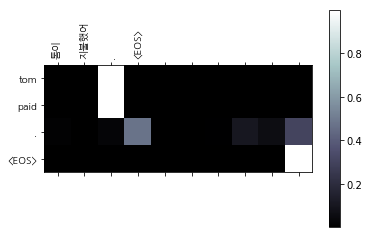

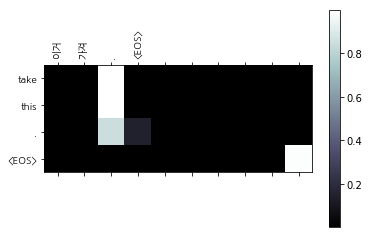

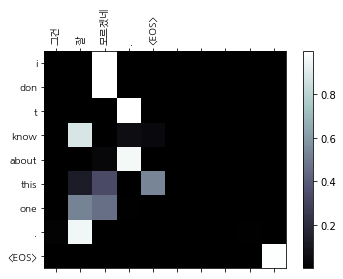

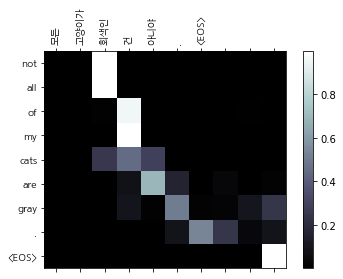

In [49]:
trainer.evaluateAndShowAttention("톰이 지불했어 .")

trainer.evaluateAndShowAttention("이거 가져 .")

trainer.evaluateAndShowAttention("그건 잘 모르겠네 .")

trainer.evaluateAndShowAttention("모든 고양이가 회색인 건 아니야 .")

import matplotlib as mpl

print ('버전: ', mpl.__version__)
print ('설치 위치: ', mpl.__file__)
print ('설정 위치: ', mpl.get_configdir())
print ('캐시 위치: ', mpl.get_cachedir())
print ('설정 파일 위치: ', mpl.matplotlib_fname())

import matplotlib.font_manager as fm
font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
print(len(font_list))
f = [f.name for f in fm.fontManager.ttflist]
print(f)
[(f.name, f.fname) for f in fm.fontManager.ttflist if 'Nanum' in f.name]